# Introdução

Código desenvolvido para o projeto final da disciplina EBM116 – Tópicos Avançados em Imagens Médicas do programa de pós-graduação em Engenharia Biomédica da Universidade Federal do ABC (UFABC). O objetivo do projeto foi avaliar a performance de uma rede neural convolucional na tarefa de aumentar a resolução de imagens de ressonância magnética da cabeça humana.

Autor: Leonardo Alves Ferreira

# Sumário

1. [Preparo das imagens](#parte_1)
2. [Criação das matrizes de treino e validação](#parte_2)
3. [Configuração da rede neural](#parte_3)
4. [Treino da rede neural](#parte_4)
5. [Resultado das imagens de validação](#parte_5)
6. [Comparação com a interpolação](#parte_6)
7. [Testes com uma imagem com câncer](#parte_7)

# Preparo das imagens <a name="parte_1"></a>

Foram utilizadas 50 imagens de ressonância magnética da cabeça obtidas do <a href="https://www.insight-journal.org/midas/community/view/21">MIDAS</a>. Foram utilizadas fatias de regiões próximas ao cérebro, eliminando imagens que estivessem mais para as extremidades.

In [1]:
import numpy as np
import nibabel as nib
import nibabel.processing as nibp
import cv2
import pydicom as pdc
import glob
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

In [2]:
# Criar uma lista com o caminho das imagens
list_img = glob.glob("Imagens\\Treino\\*\\*.nii", recursive=True)
imgs_path = []

for i in range(len(list_img)):
    if(list_img[i].count(".")==1):
        imgs_path.append(list_img[i][0:list_img[i].find(".nii")] + '.nii')

In [3]:
def pre_process(path_img, min_porc=0.01):
    # Importar a imagem
    img=nib.load(path_img)
    img=img.get_fdata()
    
    # Limitar o valor máximo de intensidade
    hist,bins = np.histogram(img.flatten(),100)
    hist=hist/np.size(img)*100
    mask=hist>min_porc
    val_max=np.max(mask*bins[0:-1])
    img_n=np.clip(img,0,val_max)
    
    return img_n

def resize_image(img,dim=(80,80)):
    # Alterar o tamanho da imagem
    img_n=[]
    
    for i in range(img.shape[2]):
        temp=cv2.resize(img[:,:,i], dim, interpolation=cv2.INTER_CUBIC)
        img_n.append(temp)

    img_n=np.array(img_n)
    
    #Normalizar intensidades entre 0 e 1
    img_n=img_n/np.max(img_n)
    
    return img_n

def matrix_image(imgs_path,slice_range=(50,130)):
    img=pre_process(imgs_path[0])
    img=resize_image(img)
    all_img=img[slice_range[0]:slice_range[1]+1,:,:]
    
    for i in range(1,len(imgs_path)):
        img=pre_process(imgs_path[i])
        img=resize_image(img)
        
        all_img=np.concatenate([all_img,img[slice_range[0]:slice_range[1]+1,:,:]],0)
    
    return all_img

In [4]:
# Obter a matriz com todas as imagens
all_img=matrix_image(imgs_path)

In [5]:
print(f"Dimensão da matriz das imagens: {all_img.shape}")

Dimensão da matriz das imagens: (4050, 80, 80)


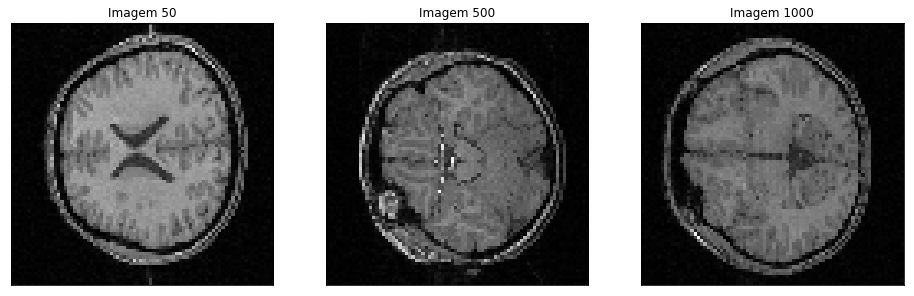

In [6]:
gmap="Greys_r"
inds=[50,500,1000]

plt.figure(figsize=(16,16))

plt.subplot(1,3,1)
plt.imshow(all_img[inds[0],:,:],cmap=gmap,vmin=0,vmax=1)
plt.title(f"Imagem {inds[0]}"), plt.xticks([]), plt.yticks([])

plt.subplot(1,3,2)
plt.imshow(all_img[inds[1],:,:],cmap=gmap,vmin=0,vmax=1)
plt.title(f"Imagem {inds[1]}"), plt.xticks([]), plt.yticks([])

plt.subplot(1,3,3)
plt.imshow(all_img[inds[2],:,:],cmap=gmap,vmin=0,vmax=1)
plt.title(f"Imagem {inds[2]}"), plt.xticks([]), plt.yticks([])


plt.show();

# Criação das matrizes de treino e validação <a name=parte_2></a>

As imagens das primeiras 48 pessoas foram utilizadas para o treino da rede neural, enquanto as últimas duas e a imagem com câncer foram utilizadas para os testes a serem realizados posteriormente.

In [7]:
def downsample_rescale(img, down_fac=0.4):
    # Diminuir resolução
    width=int(img.shape[1]*down_fac)
    height = int(img.shape[0]*down_fac)
    dim = (width, height)
    down_img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)

    # Retornar para o tamanho original
    down_img_r = cv2.resize(down_img, (img.shape[0],img.shape[1]), interpolation=cv2.INTER_AREA)

    return down_img_r
                            
def train_valid(all_imgs,slice_range=(50,130),num_p=48):
    # Encontrar o índice inicial das imagens de validação
    ind_v=num_p*(slice_range[1]+1-slice_range[0])
    
    # Dados de saída da rede neural (imagem na resolução original)
    train_y=all_imgs[0:ind_v,:,:]
    val_y=all_imgs[ind_v:,:,:]
    
    # Dados de entrada da rede neural (imagem na resolução diminuida)
    train_x=[]
    for i in range(train_y.shape[0]):
        temp=downsample_rescale(train_y[i,:,:])
        train_x.append(temp)
    
    train_x=np.array(train_x)
        
    val_x=[]
    for i in range(val_y.shape[0]):
        temp=downsample_rescale(val_y[i,:,:])
        val_x.append(temp)
        
    val_x=np.array(val_x)
    
    # Adicionar uma dimensão para ficar consistente com a entrada da rede neural
    train_x=np.expand_dims(train_x,3)
    train_y=np.expand_dims(train_y,3)
    val_x=np.expand_dims(val_x,3)
    val_y=np.expand_dims(val_y,3)
    
    return train_x, train_y, val_x, val_y

In [8]:
train_x, train_y, val_x, val_y = train_valid(all_img)

In [9]:
print(f"Dimensão do treino: {train_x.shape}\nDimensão da validação: {val_x.shape}")

Dimensão do treino: (3888, 80, 80, 1)
Dimensão da validação: (162, 80, 80, 1)


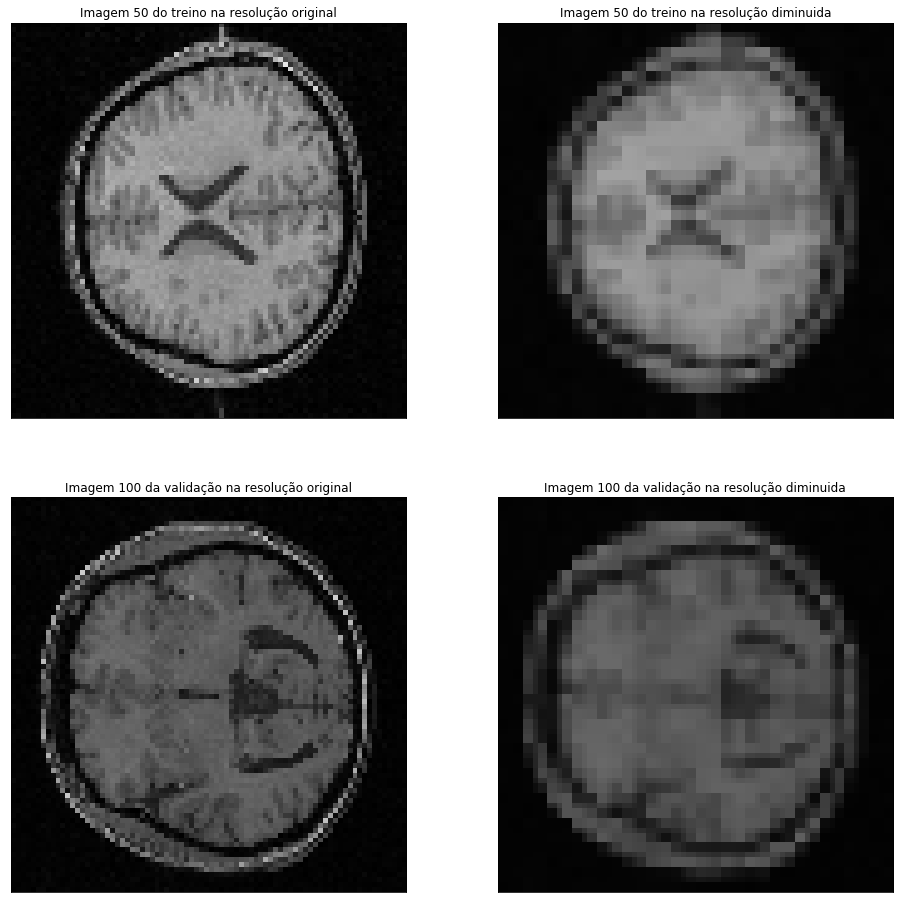

In [10]:
inds=[50,100]

plt.figure(figsize=(16,16))

plt.subplot(2,2,1)
plt.imshow(train_y[inds[0],:,:,0],cmap=gmap,vmin=0,vmax=1)
plt.title(f"Imagem {inds[0]} do treino na resolução original"), plt.xticks([]), plt.yticks([])

plt.subplot(2,2,2)
plt.imshow(train_x[inds[0],:,:,0],cmap=gmap,vmin=0,vmax=1)
plt.title(f"Imagem {inds[0]} do treino na resolução diminuida"), plt.xticks([]), plt.yticks([])

plt.subplot(2,2,3)
plt.imshow(val_y[inds[1],:,:,0],cmap=gmap,vmin=0,vmax=1)
plt.title(f"Imagem {inds[1]} da validação na resolução original"), plt.xticks([]), plt.yticks([])

plt.subplot(2,2,4)
plt.imshow(val_x[inds[1],:,:,0],cmap=gmap,vmin=0,vmax=1)
plt.title(f"Imagem {inds[1]} da validação na resolução diminuida"), plt.xticks([]), plt.yticks([])

plt.show();

# Configuração da rede neural <a name="parte_3"></a>

O código para a formulação da rede neural foi baseado no código disponibilizado na <a href="https://towardsdatascience.com/image-super-resolution-using-convolution-neural-networks-and-auto-encoders-28c9eceadf90">Towards Data Science</a>.

In [30]:
import tensorflow as tf
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import image

In [15]:
Input_img = Input(shape=(80,80,1))  
    
#encoding architecture
x1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(Input_img)
x2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x1)
x3 = MaxPool2D(padding='same')(x2)

x4 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x3)
x5 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x4)
x6 = MaxPool2D(padding='same')(x5)

encoded = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x6)

# decoding architecture
x7 = UpSampling2D()(encoded)
x8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x7)
x9 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x8)
x10 = Add()([x5, x9])

x11 = UpSampling2D()(x10)
x12 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x11)
x13 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x12)
x14 = Add()([x2, x13])

decoded = Conv2D(1, (3, 3), padding='same',activation='relu', kernel_regularizer=regularizers.l1(10e-10))(x14)

autoencoder = Model(Input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [29]:
autoencoder.summary()
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=50, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint('1channel_3888tr162va.h5',save_best_only=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 80, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 80, 80, 64)   36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 40, 40, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

# Treino da rede neural <a name="parte_4"></a>

In [30]:
history = autoencoder.fit(train_x,train_y,
            epochs=100,
            validation_data=(val_x, val_y),
            callbacks=[early_stopper, model_checkpoint])


Train on 3888 samples, validate on 162 samples
Epoch 1/100
3888/3888 [==============================] - 62s 16ms/sample - loss: 0.0037 - val_loss: 0.0026
Epoch 2/100
3888/3888 [==============================] - 60s 15ms/sample - loss: 0.0032 - val_loss: 0.0024
Epoch 3/100
3888/3888 [==============================] - 61s 16ms/sample - loss: 0.0028 - val_loss: 0.0023
Epoch 4/100
3888/3888 [==============================] - 61s 16ms/sample - loss: 0.0025 - val_loss: 0.0020
Epoch 5/100
3888/3888 [==============================] - 61s 16ms/sample - loss: 0.0024 - val_loss: 0.0018
Epoch 6/100
3888/3888 [==============================] - 63s 16ms/sample - loss: 0.0023 - val_loss: 0.0018
Epoch 7/100
3888/3888 [==============================] - 61s 16ms/sample - loss: 0.0022 - val_loss: 0.0018
Epoch 8/100
3888/3888 [==============================] - 62s 16ms/sample - loss: 0.0022 - val_loss: 0.0018
Epoch 9/100
3888/3888 [==============================] - 62s 16ms/sample - loss: 0.0021 - val_los

# Resultado das imagens de validação <a name="parte_5"></a>

In [11]:
autoencoder = tf.keras.models.load_model('1channel_3888tr162va.h5')

In [12]:
predictions = autoencoder.predict(val_x)

In [13]:
predictions.shape

(162, 80, 80, 1)

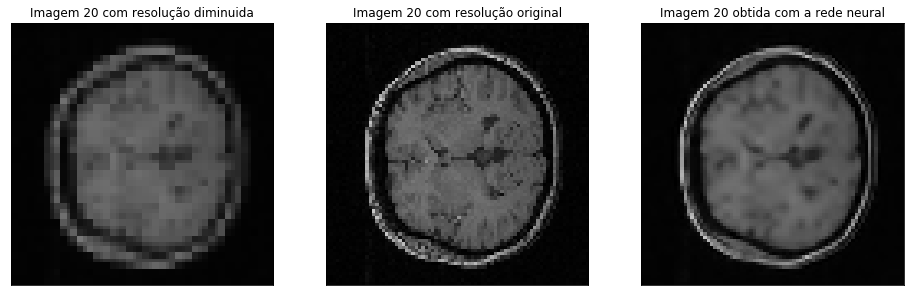

In [14]:
inds=[20]

plt.figure(figsize=(16,16))

plt.subplot(1,3,1)
plt.imshow(val_x[inds[0],:,:,0],cmap=gmap,vmin=0,vmax=1)
plt.title(f"Imagem {inds[0]} com resolução diminuida"), plt.xticks([]), plt.yticks([])

plt.subplot(1,3,2)
plt.imshow(val_y[inds[0],:,:,0],cmap=gmap,vmin=0,vmax=1)
plt.title(f"Imagem {inds[0]} com resolução original"), plt.xticks([]), plt.yticks([])

plt.subplot(1,3,3)
plt.imshow(predictions[inds[0],:,:,0],cmap=gmap,vmin=0,vmax=1)
plt.title(f"Imagem {inds[0]} obtida com a rede neural"), plt.xticks([]), plt.yticks([])

plt.show()

# Comparação com a interpolação <a name="parte_6"></a>

Os resultados obtidos com a rede neural foram comparados com o que se obtém utilizando a interpolação cúbica.

In [15]:
def downsample(img, down_fac=0.4):
    # Diminuir resolução
    width=int(img.shape[1]*down_fac)
    height = int(img.shape[0]*down_fac)
    dim = (width, height)
    down_img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)

    return down_img

def rescale(img,dim_orig=(80,80)):
    img_r = cv2.resize(img, dim_orig, interpolation=cv2.INTER_CUBIC)
    
    return img_r
    
def res_cubic(all_imgs,slice_range=(50,130),num_p=48):
    # Encontrar o índice inicial das imagens de validação
    ind_v=num_p*(slice_range[1]+1-slice_range[0])
    
    # Dados de saída da rede neural (imagem na resolução original)
    val_y=all_imgs[ind_v:,:,:]
    
    interps=[]
    
    for i in range(val_y.shape[0]):
        down=downsample(val_y[i,:,:])
        down_r=rescale(down)
        interps.append(down_r)
    
    interps=np.array(interps)
    
    return interps

In [16]:
interps=res_cubic(all_img)

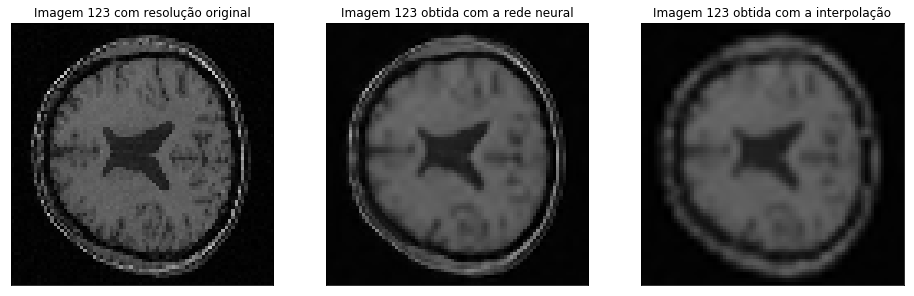

In [40]:
inds=[123]

plt.figure(figsize=(16,16))

plt.subplot(1,3,1)
plt.imshow(val_y[inds[0],:,:,0],cmap=gmap,vmin=0,vmax=1)
plt.title(f"Imagem {inds[0]} com resolução original"), plt.xticks([]), plt.yticks([])

plt.subplot(1,3,2)
plt.imshow(predictions[inds[0],:,:,0],cmap=gmap,vmin=0,vmax=1)
plt.title(f"Imagem {inds[0]} obtida com a rede neural"), plt.xticks([]), plt.yticks([])

plt.subplot(1,3,3)
plt.imshow(interps[inds[0],:,:],cmap=gmap,vmin=0,vmax=1)
plt.title(f"Imagem {inds[0]} obtida com a interpolação"), plt.xticks([]), plt.yticks([])

plt.show()

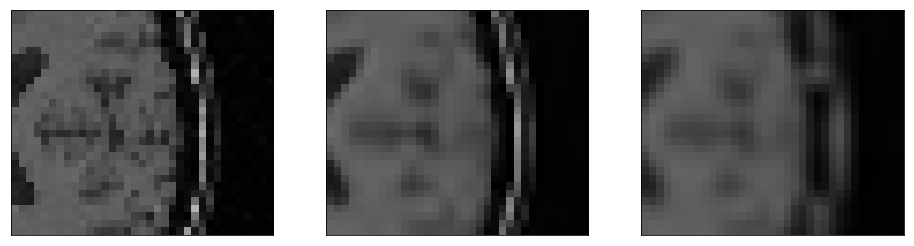

In [39]:
zy=[25,55]
zx=[45,85]

plt.figure(figsize=(16,16))

plt.subplot(1,3,1)
plt.imshow(val_y[inds[0],zy[0]:zy[1],zx[0]:zx[1],0],cmap=gmap,vmin=0,vmax=1)
#plt.title(f"Imagem {inds[0]} com resolução original")
plt.xticks([]), plt.yticks([])

plt.subplot(1,3,2)
plt.imshow(predictions[inds[0],zy[0]:zy[1],zx[0]:zx[1],0],cmap=gmap,vmin=0,vmax=1)
#plt.title(f"Imagem {inds[0]} obtida com a rede neural")
plt.xticks([]), plt.yticks([])

plt.subplot(1,3,3)
plt.imshow(interps[inds[0],zy[0]:zy[1],zx[0]:zx[1]],cmap=gmap,vmin=0,vmax=1)
#plt.title(f"Imagem {inds[0]} obtida com a interpolação")
plt.xticks([]), plt.yticks([])

plt.show()

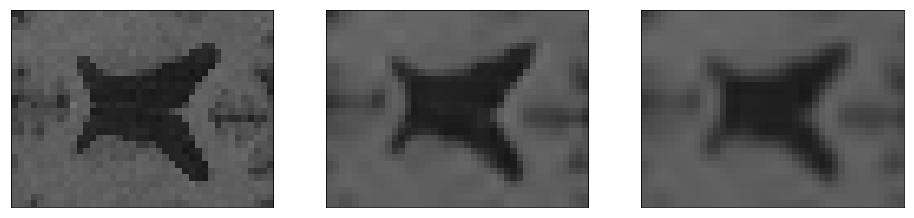

In [41]:
zy=[25,55]
zx=[18,58]

plt.figure(figsize=(16,16))

plt.subplot(1,3,1)
plt.imshow(val_y[inds[0],zy[0]:zy[1],zx[0]:zx[1],0],cmap=gmap,vmin=0,vmax=1)
#plt.title(f"Imagem {inds[0]} com resolução original")
plt.xticks([]), plt.yticks([])

plt.subplot(1,3,2)
plt.imshow(predictions[inds[0],zy[0]:zy[1],zx[0]:zx[1],0],cmap=gmap,vmin=0,vmax=1)
#plt.title(f"Imagem {inds[0]} obtida com a rede neural")
plt.xticks([]), plt.yticks([])

plt.subplot(1,3,3)
plt.imshow(interps[inds[0],zy[0]:zy[1],zx[0]:zx[1]],cmap=gmap,vmin=0,vmax=1)
#plt.title(f"Imagem {inds[0]} obtida com a interpolação")
plt.xticks([]), plt.yticks([])

plt.show()

In [23]:
ssim_neural=ssim(predictions[:,:,:,0],val_y[:,:,:,0])
ssim_interp=ssim(interps[:,:,:],val_y[:,:,:,0])

print(f"SSIM da rede neural: {ssim_neural}\nSSIM da interpolação: {ssim_interp}")

C:\Users\guys_\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  """Entry point for launching an IPython kernel.


SSIM da rede neural: 0.9075755464540624
SSIM da interpolação: 0.8236694106059445


In [25]:
ssim_sum=0

for i in range(predictions.shape[0]):
    ssim_sum= ssim_sum + ssim(predictions[i,:,:,0],val_y[i,:,:,0])
    
ssim_med=ssim_sum/predictions.shape[0]
print(ssim_med)

ssim_sum=0

for i in range(predictions.shape[0]):
    ssim_sum= ssim_sum + ssim(interps[i,:,:],val_y[i,:,:,0])
    
ssim_med=ssim_sum/predictions.shape[0]
print(ssim_med)

C:\Users\guys_\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  after removing the cwd from sys.path.


0.904192894752088
0.8216075430757981


In [27]:
def calc_ssim(rec,true):
    ssim_vec=[]
    
    for i in range(true.shape[0]):
        ssim_vec.append(ssim(rec[i,:,:],true[i,:,:]))
        
    ssim_vec=np.array(ssim_vec)
    
    return ssim_vec

In [52]:
ssim_neural=calc_ssim(predictions[:,:,:,0],val_y[:,:,:,0])
ssim_interp=calc_ssim(interps,val_y[:,:,:,0])

C:\Users\guys_\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  """


In [48]:
from scipy.stats import shapiro, wilcoxon
import seaborn as sns

Como foi verificado que os dados não seguem uma distrubuição normal, e os dados dos dois grupos são de amostras dependentes, o teste de Wilcoxon foi utilizado para verificar a significância estatística da diferença encontrada entre os resultados

In [30]:
shapiro_neural=shapiro(ssim_neural)
shapiro_interps=shapiro(ssim_interp)
test_p=wilcoxon(ssim_neural,ssim_interp,alternative='greater')

print(f"p_neural={shapiro_neural.pvalue}\np_interps={shapiro_interps.pvalue}\np={test_p.pvalue}")

p_neural=0.00410486338660121
p_interps=2.476863825151554e-09
p=1.2299634204180834e-28


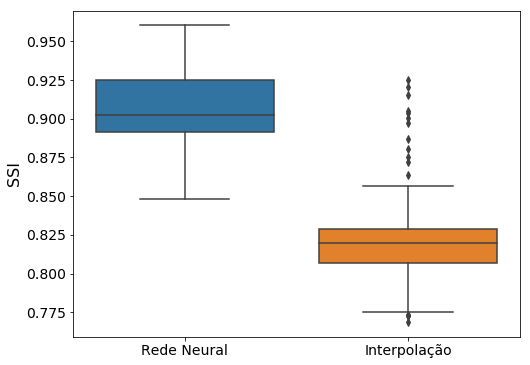

In [66]:
plt.figure(figsize=(8,6))
sns.boxplot(data=[ssim_neural,ssim_interp])
bplot.artists[0].set_facecolor("red")
#bplot.artists[1].set_facecolor("white")
plt.ylabel("SSI",fontsize=16)
plt.yticks(fontsize=14)

plt.xticks(plt.xticks()[0], ['Rede Neural','Interpolação'], fontsize=14);

In [78]:
np.where(ssim_interp<0.77)

(array([91], dtype=int64),)

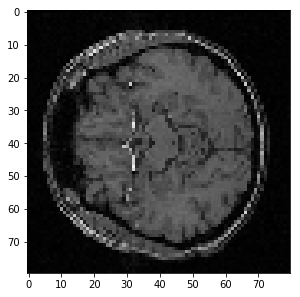

In [80]:
plt.figure(figsize=(16,16))

plt.subplot(1,3,1)
plt.imshow(val_y[91,:,:,0],cmap=gmap,vmin=0,vmax=1);

# Testes com uma imagem com câncer <a name="parte_7"></a>

Uma imagem da cabeça de uma pessoa com câncer também foi utilizada para avaliar a performance das técnicas. A imagem foi obtida do <a href="https://www.cancerimagingarchive.net">Cancer Image Archive</a>.

In [32]:
path="Imagens/Teste/1-15.dcm"
img_cancer=pdc.dcmread(path)
img_cancer=img_cancer.pixel_array

# Rotacionar para ficar na mesma posição que as outras
img_cancer=np.rot90(img_cancer)

# Colocar nas mesmas dimensões
img_cancer=np.expand_dims(img_cancer,2)
img_cancer=resize_image(img_cancer)[0,:,:]

# Obter as versões com resolução diminuida
downimg_cancer_neural=downsample_rescale(img_cancer)
downimg_cancer_interp=downsample(img_cancer)

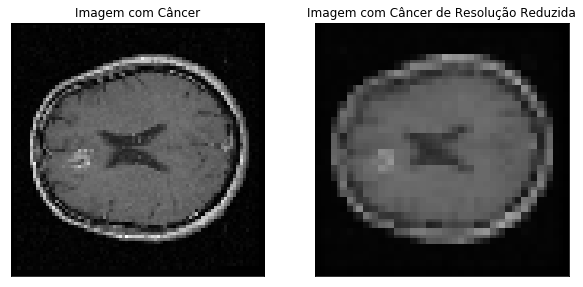

In [33]:
plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(img_cancer,cmap=gmap,vmin=0,vmax=1)
plt.title(f"Imagem com Câncer"), plt.xticks([]), plt.yticks([]);

plt.subplot(1,2,2)
plt.imshow(downimg_cancer_neural,cmap=gmap,vmin=0,vmax=1)
plt.title(f"Imagem com Câncer de Resolução Reduzida"), plt.xticks([]), plt.yticks([]);

In [34]:
# Colocar nas dimensões adequadas para a predição com a rede neural
downimg_cancer_neural=np.expand_dims(downimg_cancer_neural,0)
downimg_cancer_neural=np.expand_dims(downimg_cancer_neural,3)

# Obter as imagens de resolução aumentada
#img_cancer_neural=autoencoder.predict(downimg_cancer_neural)
img_cancer_neural=np.load("img_cancer_neural.npy")
img_cancer_neural=img_cancer_neural[0,:,:,0]
img_cancer_interp=rescale(downimg_cancer_interp)

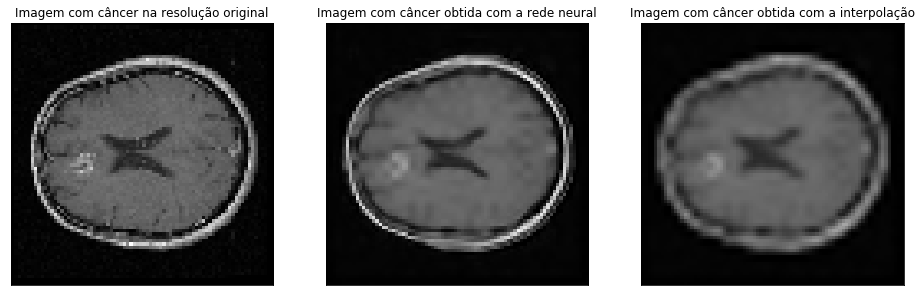

In [35]:
plt.figure(figsize=(16,16))

plt.subplot(1,3,1)
plt.imshow(img_cancer,cmap=gmap,vmin=0,vmax=1)
plt.title(f"Imagem com câncer na resolução original"), plt.xticks([]), plt.yticks([])

plt.subplot(1,3,2)
plt.imshow(img_cancer_neural,cmap=gmap,vmin=0,vmax=1)
plt.title(f"Imagem com câncer obtida com a rede neural"), plt.xticks([]), plt.yticks([])

plt.subplot(1,3,3)
plt.imshow(img_cancer_interp,cmap=gmap,vmin=0,vmax=1)
plt.title(f"Imagem com câncer obtida com a interpolação"), plt.xticks([]), plt.yticks([])

plt.show()

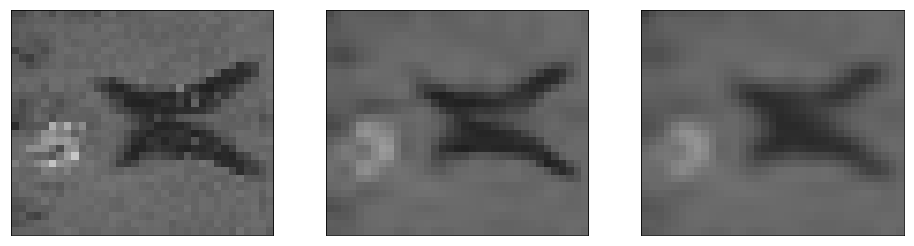

In [81]:
zy=[25,55]
zx=[16,51]

plt.figure(figsize=(16,16))

plt.subplot(1,3,1)
plt.imshow(img_cancer[zy[0]:zy[1],zx[0]:zx[1]],cmap=gmap,vmin=0,vmax=1)
#plt.title(f"Imagem {inds[0]} com resolução original")
plt.xticks([]), plt.yticks([])

plt.subplot(1,3,2)
plt.imshow(img_cancer_neural[zy[0]:zy[1],zx[0]:zx[1]],cmap=gmap,vmin=0,vmax=1)
#plt.title(f"Imagem {inds[0]} obtida com a rede neural")
plt.xticks([]), plt.yticks([])

plt.subplot(1,3,3)
plt.imshow(img_cancer_interp[zy[0]:zy[1],zx[0]:zx[1]],cmap=gmap,vmin=0,vmax=1)
#plt.title(f"Imagem {inds[0]} obtida com a interpolação")
plt.xticks([]), plt.yticks([])

plt.show()

In [37]:
ssim_neural=ssim(img_cancer_neural,img_cancer)
ssim_interp=ssim(img_cancer_interp,img_cancer)

print(f"SSIM da rede neural: {ssim_neural}\nSSIM da interpolação: {ssim_interp}")

SSIM da rede neural: 0.8941969270614964
SSIM da interpolação: 0.821690005728581


C:\Users\guys_\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  """Entry point for launching an IPython kernel.
